In [1]:
import pandas as pd
import numpy as np
from utils import *

/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
nonpredictors = ['enhancer_chrom', 'enhancer_start', 'enhancer_end', 
                 'promoter_chrom', 'promoter_start', 'promoter_end', 
                 'window_chrom', 'window_start', 'window_end', 'window_name', 
                 'active_promoters_in_window', 'interactions_in_window', 
                 'enhancer_distance_to_promoter', 'bin', 'label',
                 'promoter_seq', 'enhancer_seq'] 


In [3]:
np.random.seed(0)

In [4]:
data = pd.read_csv('datasets/training_huvec.csv')
data.head()

,bin,enhancer_chrom,enhancer_distance_to_promoter,enhancer_end,enhancer_name,enhancer_start,label,promoter_chrom,promoter_end,promoter_name,...,H3K79me2 (window),H3K9ac (window),H3K9me1 (window),H3K9me3 (window),H4K20me1 (window),JUN (window),MAX (window),MYC (window),POLR2A (window),CAGE (window)
0,"[33835, 131310.8]",chr1,119012,3421842,HUVEC|chr1:3420459-3421842,3420459,1,chr1,3541719,HUVEC|chr1:3540856-3541719,...,0.000027,0.000669,0.000027,0.000000,0.000000,0.000630,0.000931,0.000000,0.000000,0.001136
1,"(305587.4, 495816.4]",chr1,482121,12193661,HUVEC|chr1:12193000-12193661,12193000,1,chr1,12680000,HUVEC|chr1:12675784-12680000,...,0.000341,0.000594,0.000007,0.000015,0.000015,0.001653,0.000306,0.000111,0.000227,0.001724
2,"(131310.8, 218794.8]",chr1,174270,16127559,HUVEC|chr1:16125278-16127559,16125278,1,chr1,16302773,HUVEC|chr1:16301831-16302773,...,0.003975,0.001021,0.000070,0.000000,0.000321,0.001471,0.000173,0.000114,0.001276,0.003684
3,"(218794.8, 305587.4]",chr1,277180,16400647,HUVEC|chr1:16399453-16400647,16399453,1,chr1,16679559,HUVEC|chr1:16677829-16679559,...,0.001545,0.000837,0.000055,0.000011,0.000172,0.001725,0.000368,0.000294,0.000392,0.002151
4,"(218794.8, 305587.4]",chr1,274977,16402850,HUVEC|chr1:16402337-16402850,16402337,1,chr1,16679559,HUVEC|chr1:16677829-16679559,...,0.001558,0.000843,0.000056,0.000012,0.000173,0.001646,0.000371,0.000297,0.000395,0.002169


In [5]:
data['enhancer_seq'] = data.apply(lambda x: fetch_seq(x['enhancer_start'],
                                                      x['enhancer_end'],
                                                      x['enhancer_chrom']),
                                  axis=1)

mean      690.581537
median    402.000000
std       791.613518
Name: enhancer_seq, dtype: float64


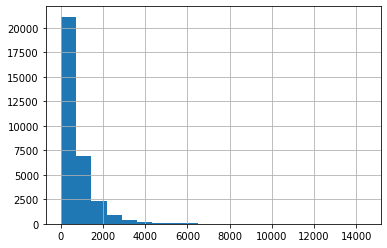

In [6]:
data['enhancer_seq'].apply(len).hist(bins=20)
print(data['enhancer_seq'].apply(len).agg(['mean', 'median', 'std']))

In [7]:
data['promoter_seq'] = data.apply(lambda x: fetch_seq(x['promoter_start'],
                                                      x['promoter_end'],
                                                      x['promoter_chrom']),
                                  axis=1)

mean      1483.891900
median    1314.000000
std        933.313129
Name: promoter_seq, dtype: float64


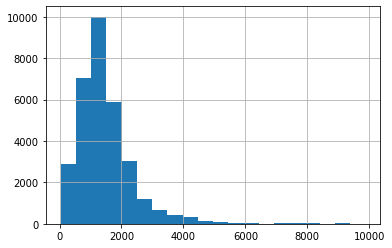

In [8]:
data['promoter_seq'].apply(len).hist(bins=20)
print(data['promoter_seq'].apply(len).agg(['mean', 'median', 'std']))

In [9]:
data[(data.promoter_seq.apply(len) > 3000) |
    (data.enhancer_seq.apply(len) > 3000)].shape[0] / data.shape[0]

0.07602430773086079

In [10]:
data['promoter_seq_words'] = data['promoter_seq'].apply(split_to_kmers)
data['enhancer_seq_words'] = data['enhancer_seq'].apply(split_to_kmers)

In [11]:
data = data.set_index(['enhancer_name', 'promoter_name'])
train_valid, test = train_test_split(data, test_size=0.1, random_state=0, stratify=data['label'])
train, valid = train_test_split(train_valid, test_size=0.2, random_state=0, stratify=train_valid['label'])

<AxesSubplot:>

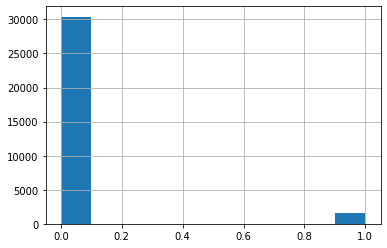

In [12]:
data.label.hist()

In [13]:
train_valid_upsampled = upsample(train_valid, 1)
train_upsampled = upsample(train, 1)

In [14]:
labels = {
    'train': train['label'],
    'train_upsampled': train_upsampled['label'],
    'test': test['label'],
    'valid': valid['label'],
    'train_valid': train_valid['label'],
    'train_valid_upsampled': train_valid_upsampled['label']
}

In [15]:
to_drop = nonpredictors + ['promoter_seq_words', 'enhancer_seq_words']
tf_x = {
    'train': train.drop(to_drop, axis=1),
    'train_upsampled': train_upsampled.drop(to_drop, axis=1),
    'test': test.drop(to_drop, axis=1),
    'valid': valid.drop(to_drop, axis=1),
    'train_valid': train_valid.drop(to_drop, axis=1),
    'train_valid_upsampled': train_valid_upsampled.drop(to_drop, axis=1)
}

# TF model

In [16]:
est_tf = GradientBoostingClassifier(n_estimators = 4000, learning_rate = 0.1,
                                       max_depth = 5, max_features = 'log2', 
                                       random_state = 0)
est_tf.fit(tf_x['train_valid_upsampled'], labels['train_valid_upsampled'])
f1_score(labels['test'],
        est_tf.predict(tf_x['test']))

0.781021897810219

In [17]:
precision_score(labels['test'], est_tf.predict(tf_x['test'])),\
recall_score(labels['test'], est_tf.predict(tf_x['test']))

(0.8770491803278688, 0.7039473684210527)

# GB sequences model

In [18]:
promoters_dna2vec = dna2vec(s=30)
promoters_dna2vec.fit(train_valid.promoter_seq_words.values)
enhancers_dna2vec = dna2vec(s=30)
enhancers_dna2vec.fit(train_valid.enhancer_seq_words.values)

In [19]:
seq_avg_x = {}
for name, df in zip(
    ['train', 'valid', 'test', 'train_valid', 'train_upsampled', 'train_valid_upsampled'],
    [train, valid, test, train_valid, train_upsampled, train_valid_upsampled] ):
    promoters = transform_to_avg_vec(df.promoter_seq_words.values,
                                     promoters_dna2vec,
                                     'promoter')
    enhancers = transform_to_avg_vec(df.enhancer_seq_words.values,
                                     enhancers_dna2vec,
                                     'enhancer')
    seq_avg_x[name] = pd.concat((promoters, enhancers), axis=1)

In [20]:
estimator_seq_avg = GradientBoostingClassifier(learning_rate = 0.1, random_state = 0,
                                                  n_estimators = 4000, max_depth = 5, 
                                                  max_features = 'sqrt')
estimator_seq_avg.fit(seq_avg_x['train_valid_upsampled'], labels['train_valid_upsampled'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=4000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [21]:
f1_score(labels['test'], 
         estimator_seq_avg.predict(seq_avg_x['test']))

0.40366972477064217

In [22]:
precision_score(labels['test'], 
         estimator_seq_avg.predict(seq_avg_x['test'])),\
recall_score(labels['test'], 
         estimator_seq_avg.predict(seq_avg_x['test']))

(0.6666666666666666, 0.2894736842105263)

# Combined TF&GB Sequences

In [23]:
est_tf_trainonly = GradientBoostingClassifier(n_estimators = 4000, learning_rate = 0.1,
                                       max_depth = 5, max_features = 'log2', 
                                       random_state = 0).fit(tf_x['train_upsampled'],
                                                            labels['train_upsampled'])

In [24]:
est_seq_avg_trainonly = GradientBoostingClassifier(learning_rate = 0.1, random_state = 0,
                                                  n_estimators = 4000, max_depth = 5, 
                                                  max_features = 'sqrt')
est_seq_avg_trainonly.fit(seq_avg_x['train_upsampled'],
                         labels['train_upsampled'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=4000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
est_tf_valid_prob = est_tf_trainonly.predict_proba(tf_x['valid'])
est_seq_avg_valid_prob = est_seq_avg_trainonly.predict_proba(seq_avg_x['valid'])

In [26]:
est_combined_seq_avg = GradientBoostingClassifier(learning_rate=0.05, random_state=0,
                                                  n_estimators=20, max_depth=2)
est_combined_seq_avg.fit(np.concatenate((est_tf_valid_prob, est_seq_avg_valid_prob), axis=1),
                        labels['valid'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [27]:
est_tf_test_prob = est_tf.predict_proba(tf_x['test'])
est_seq_avg_test_prob = estimator_seq_avg.predict_proba(seq_avg_x['test'])

In [28]:
combined_pred_seq = est_combined_seq_avg.predict(
    np.concatenate((est_tf_test_prob, est_seq_avg_test_prob), axis=1)
)

In [29]:
f1_score(labels['test'], combined_pred_seq)

0.7854545454545453

In [30]:
precision_score(labels['test'], combined_pred_seq),\
recall_score(labels['test'], combined_pred_seq)

(0.8780487804878049, 0.7105263157894737)

# NN

In [31]:
train_valid_nn = filter_seq_length(train_valid, 3000)

In [32]:
promoters_tokenizer = dna_tokenizer(sent_size=600)
promoters_tokenizer.fit(train_valid_nn.promoter_seq_words.values)
enhancers_tokenizer = dna_tokenizer(sent_size=600)
enhancers_tokenizer.fit(train_valid_nn.enhancer_seq_words.values)

In [33]:
promoters_embeddins = get_embeddings_matrix(promoters_dna2vec, 
                                            promoters_tokenizer)
enhancers_embeddins = get_embeddings_matrix(enhancers_dna2vec, 
                                            enhancers_tokenizer)

In [34]:
seq_nn_x = {}
labels_nn = {}

for name, df in zip(
    ['train', 'valid', 'test', 'train_valid', 'train_upsampled', 'train_valid_upsampled'],
    [train, valid, test, train_valid, train_upsampled, train_valid_upsampled] ):
    df_filtered = filter_seq_length(df)
    promoters = promoters_tokenizer.transform(df_filtered['promoter_seq_words'].values)
    enhancers = enhancers_tokenizer.transform(df_filtered['enhancer_seq_words'].values)
    seq_nn_x[name] = [promoters, enhancers]
    labels_nn[name] = df_filtered['label']

In [35]:
seq_nn_trainonly = get_model(promoters_embeddins, enhancers_embeddins,
                            n_filters=6, sent_size=600)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:
seq_nn_trainonly.fit(x=seq_nn_x['train_upsampled'],
            y=labels_nn['train_upsampled'],
            epochs=5, batch_size=8)

Epoch 1/5
24782/24782 [==============================] - 204s 8ms/sample - loss: 0.5194 - acc: 0.7813
Epoch 2/5
24782/24782 [==============================] - 200s 8ms/sample - loss: 0.4219 - acc: 0.8253
Epoch 3/5
24782/24782 [==============================] - 195s 8ms/sample - loss: 0.2404 - acc: 0.9129
Epoch 4/5
24782/24782 [==============================] - 196s 8ms/sample - loss: 0.1474 - acc: 0.9458
Epoch 5/5
24782/24782 [==============================] - 200s 8ms/sample - loss: 0.1061 - acc: 0.9619


In [37]:
seq_nn = get_model(promoters_embeddins, enhancers_embeddins,
                            n_filters=6, sent_size=600)
seq_nn.fit(x=seq_nn_x['train_valid_upsampled'],
            y=labels_nn['train_valid_upsampled'],
            epochs=5, batch_size=8)

Epoch 1/5
30816/30816 [==============================] - 242s 8ms/sample - loss: 0.4336 - acc: 0.8342
Epoch 2/5
30816/30816 [==============================] - 251s 8ms/sample - loss: 0.2525 - acc: 0.9216
Epoch 3/5
30816/30816 [==============================] - 255s 8ms/sample - loss: 0.1889 - acc: 0.9355
Epoch 4/5
30816/30816 [==============================] - 247s 8ms/sample - loss: 0.1491 - acc: 0.9461
Epoch 5/5
30816/30816 [==============================] - 238s 8ms/sample - loss: 0.1258 - acc: 0.9549


In [38]:
test_preds_nn = seq_nn.predict(seq_nn_x['test'])

In [39]:
f1_score(labels_nn['test'],
        test_preds_nn > 0.5)

0.4354243542435424

In [40]:
precision_score(labels_nn['test'], test_preds_nn > 0.5),\
recall_score(labels_nn['test'], test_preds_nn > 0.5)

(0.3597560975609756, 0.5514018691588785)

# Combined NN&TF

In [41]:
est_tf_valid_prob_nn = est_tf_trainonly.predict_proba(tf_x['valid'].loc[labels_nn['valid'].index])

In [42]:
est_seq_nn_valid_prob = seq_nn_trainonly.predict(seq_nn_x['valid'])

In [43]:
est_combined_seq_nn = GradientBoostingClassifier(learning_rate=0.05, random_state=0,
                                                  n_estimators=20, max_depth=2)
est_combined_seq_nn.fit(np.concatenate((est_tf_valid_prob_nn, est_seq_nn_valid_prob), axis=1),
                        labels_nn['valid'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [44]:
est_tf_test_prob_nn = est_tf.predict_proba(tf_x['test'].loc[labels_nn['test'].index])

In [45]:
preds_combined_nn = est_combined_seq_nn.predict(
    np.concatenate((est_tf_test_prob_nn, test_preds_nn), axis=1)
)

In [46]:
f1_score(labels_nn['test'], preds_combined_nn)

0.7650273224043717

In [47]:
precision_score(labels_nn['test'], preds_combined_nn),\
recall_score(labels_nn['test'], preds_combined_nn)

(0.9210526315789473, 0.6542056074766355)